# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.9 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [5]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.1450000023469329
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import namedtuple, deque
import random
import copy

In [7]:
from maddpg_v_1_0 import MADDPG
import matplotlib.pyplot as plt
import time
import numpy as np
import torch

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
agent = MADDPG(device, state_size, action_size, tau = 1e-3, gamma = 0.99, numUpdates = 1, learnSteps = 2)

In [10]:
def maddpg(n_episodes=7000, max_t=1000, solved_score=0.5, consec_episodes=100, print_every=50, train_mode=True,
         actor_path='./models/actor_ckpt.pth', critic_path='./models/critic_ckpt.pth', num_agents = 2):
    explore_period = 100000
    counter = 0
    max_scores = []                                # list of highest scores from each episode
    scores_window = deque(maxlen=consec_episodes)  # mean scores from most recent episodes
    moving_avgs = []                               # list of moving averages
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name] # reset environment
        states = env_info.vector_observations                   # get current state for each agent

        scores = np.zeros(num_agents)                           # initialize score for each agent
        agent.reset()
        start_time = time.time()
        for t in range(max_t):
            if counter < explore_period:
                noise_flag = True
            else: 
                noise_flag = False
            actions = agent.act(states, noise = noise_flag)         # select an action
            env_info = env.step(actions)[brain_name]            # send actions to environment
            next_states = env_info.vector_observations          # get next state
            rewards = env_info.rewards                          # get reward
            rewards = np.array(rewards)
            dones = env_info.local_done                        # see if episode has finished
            dones = np.array(dones)
            agent.step(states, actions, rewards, next_states, dones, t)
            states = next_states
            scores += rewards
            noise = noise * noise_factor
            counter += 1
            if np.any(dones):                                  # exit loop when episode ends
                break
                
        max_scores.append(np.max(scores))             # save highest score for a single agent        
        scores_window.append(np.max(scores))         # save mean score to window
        moving_avgs.append(np.mean(scores_window))    # save moving average
                
        if i_episode % print_every == 0:
            print('\rEpisode {} \tMov. Avg: {:.3f} \tLast Score: {:.3f}'.format(\
                  i_episode, moving_avgs[-1], max_scores[-1]))
                          
        if moving_avgs[-1] >= solved_score and i_episode >= consec_episodes:
            print('\nEnvironment SOLVED in {} episodes!\tMoving Average ={:.1f} over last {} episodes'.format(\
                                    i_episode, moving_avgs[-1], consec_episodes))            
            if train_mode:
                for idx in range(num_agents):
                    torch.save(agent.agents[idx].actor_local.state_dict(), './models/checkpoint_actor_{0}.pth'.format(idx))
                    torch.save(agent.agents[idx].critic_local.state_dict(), './models/checkpoint_critic_{0}.pth'.format(idx))  
            break
            
    return max_scores, moving_avgs

In [11]:
scores, avgs = maddpg()

Episode 50 	Mov. Avg: 0.000 	Last Score: 0.000
Episode 100 	Mov. Avg: 0.000 	Last Score: 0.000
Episode 150 	Mov. Avg: 0.001 	Last Score: 0.000
Episode 200 	Mov. Avg: 0.001 	Last Score: 0.000
Episode 250 	Mov. Avg: 0.000 	Last Score: 0.000
Episode 300 	Mov. Avg: 0.002 	Last Score: 0.000
Episode 350 	Mov. Avg: 0.003 	Last Score: 0.000
Episode 400 	Mov. Avg: 0.001 	Last Score: 0.000
Episode 450 	Mov. Avg: 0.000 	Last Score: 0.000
Episode 500 	Mov. Avg: 0.001 	Last Score: 0.000
Episode 550 	Mov. Avg: 0.001 	Last Score: 0.000
Episode 600 	Mov. Avg: 0.002 	Last Score: 0.000
Episode 650 	Mov. Avg: 0.013 	Last Score: 0.000
Episode 700 	Mov. Avg: 0.026 	Last Score: 0.000
Episode 750 	Mov. Avg: 0.041 	Last Score: 0.000
Episode 800 	Mov. Avg: 0.047 	Last Score: 0.090
Episode 850 	Mov. Avg: 0.041 	Last Score: 0.000
Episode 900 	Mov. Avg: 0.036 	Last Score: 0.100
Episode 950 	Mov. Avg: 0.033 	Last Score: 0.000
Episode 1000 	Mov. Avg: 0.034 	Last Score: 0.000
Episode 1050 	Mov. Avg: 0.038 	Last Scor

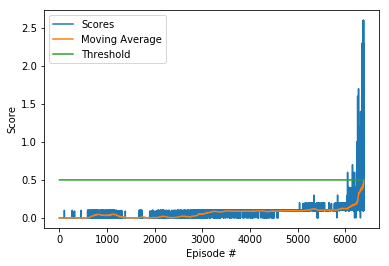

In [16]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores, label = 'Scores')
plt.plot(np.arange(len(scores)), avgs, label = 'Moving Average')
plt.plot(np.arange(len(scores)), np.full(len(scores), 0.5), label = 'Threshold')

plt.ylabel('Score')
plt.xlabel('Episode #')
plt.legend()
plt.show()

In [3]:
env.close()